In [1]:
!pip install evaluate seqeval
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ad135f24f25663c0d79637525aa5db6d71b53eccc0435d270afff598ef0d2a6c
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

## 2. Environment Setup (Coding Quality)

This section sets up the environment for the notebook, including necessary imports, device configuration, and reproducibility settings.

In [3]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from collections import Counter
import matplotlib.pyplot as plt
import os
import random
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import evaluate
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")

import logging
logging.basicConfig(level=logging.INFO)

Random seed set to 42


# Load the CoNLL-2003 dataset


In [43]:
import polars as pl

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pl.read_parquet('hf://datasets/lhoestq/conll2003/' + splits['train'])
df_validation = pl.read_parquet('hf://datasets/lhoestq/conll2003/' + splits['validation'])
df_test = pl.read_parquet('hf://datasets/lhoestq/conll2003/' + splits['test'])

In [73]:
# convert the polars dataframe to pandas dataframe
df_train_pd = df_train.to_pandas()
df_validation_pd = df_validation.to_pandas()
df_test_pd = df_test.to_pandas()

# convert the dataframe to dataset
df_train = Dataset.from_pandas(df_train_pd)
df_validation = Dataset.from_pandas(df_validation_pd)
df_test = Dataset.from_pandas(df_test_pd)

In [74]:
train_shuf = df_train.shuffle(seed=42)
val_shuf   = df_validation.shuffle(seed=42)
test_shuf  = df_test.shuffle(seed=42)

small_train      = train_shuf.select(range(1000))
small_validation = val_shuf.select(range(200))
small_test       = test_shuf.select(range(200))

dataset = {
    "train": small_train,
    "validation": small_validation,
    "test": small_test
}
print(dataset["train"][0])

{'id': '1469', 'tokens': ['"', 'Neither', 'the', 'National', 'Socialists', '(', 'Nazis', ')', 'nor', 'the', 'communists', 'dared', 'to', 'kidnap', 'an', 'American', 'citizen', ',', '"', 'he', 'shouted', ',', 'in', 'an', 'oblique', 'reference', 'to', 'his', 'extradition', 'to', 'Germany', 'from', 'Denmark', '.', '"'], 'pos_tags': [0, 12, 12, 22, 23, 4, 23, 5, 10, 12, 24, 38, 35, 37, 12, 16, 21, 6, 0, 28, 38, 6, 15, 12, 16, 21, 35, 29, 21, 35, 22, 15, 22, 7, 0], 'chunk_tags': [0, 11, 11, 12, 12, 0, 11, 0, 0, 11, 12, 21, 22, 22, 11, 12, 12, 0, 0, 11, 21, 0, 13, 11, 12, 12, 13, 11, 12, 13, 11, 13, 11, 12, 0], 'ner_tags': [0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0]}


In [75]:
print("\nFeatures of the training set:")
print(dataset["train"].features)

print("\nFirst example from the training set:")
print(dataset["train"][0])


Features of the training set:
{'id': Value('string'), 'tokens': List(Value('string')), 'pos_tags': List(Value('int64')), 'chunk_tags': List(Value('int64')), 'ner_tags': List(Value('int64'))}

First example from the training set:
{'id': '1469', 'tokens': ['"', 'Neither', 'the', 'National', 'Socialists', '(', 'Nazis', ')', 'nor', 'the', 'communists', 'dared', 'to', 'kidnap', 'an', 'American', 'citizen', ',', '"', 'he', 'shouted', ',', 'in', 'an', 'oblique', 'reference', 'to', 'his', 'extradition', 'to', 'Germany', 'from', 'Denmark', '.', '"'], 'pos_tags': [0, 12, 12, 22, 23, 4, 23, 5, 10, 12, 24, 38, 35, 37, 12, 16, 21, 6, 0, 28, 38, 6, 15, 12, 16, 21, 35, 29, 21, 35, 22, 15, 22, 7, 0], 'chunk_tags': [0, 11, 11, 12, 12, 0, 11, 0, 0, 11, 12, 21, 22, 22, 11, 12, 12, 0, 0, 11, 21, 0, 13, 11, 12, 12, 13, 11, 12, 13, 11, 13, 11, 12, 0], 'ner_tags': [0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0]}


NER Tag Distribution in Training Set:
0: 12167
5: 516
1: 445
3: 437
2: 296
7: 258
4: 253
8: 91
6: 74


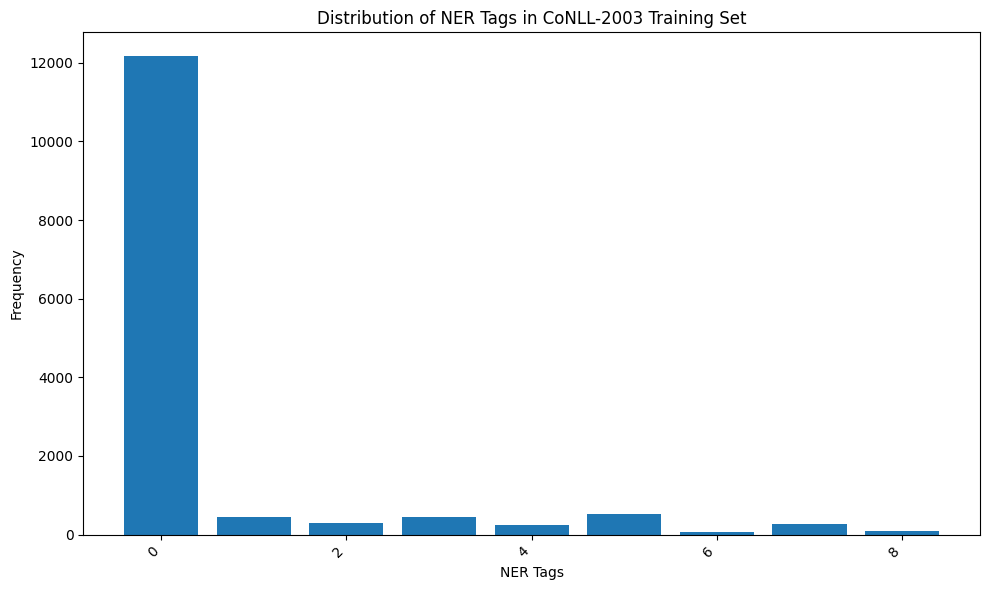

In [83]:
ner_tag_names = dataset["train"].features["ner_tags"]
all_ner_tags = [tag for example in dataset["train"]["ner_tags"] for tag in example]


tag_counts = Counter(all_ner_tags)

print("NER Tag Distribution in Training Set:")
for tag, count in tag_counts.most_common():
    print(f"{tag}: {count}")

tags = list(tag_counts.keys())
counts = list(tag_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(tags, counts)
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.title("Distribution of NER Tags in CoNLL-2003 Training Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

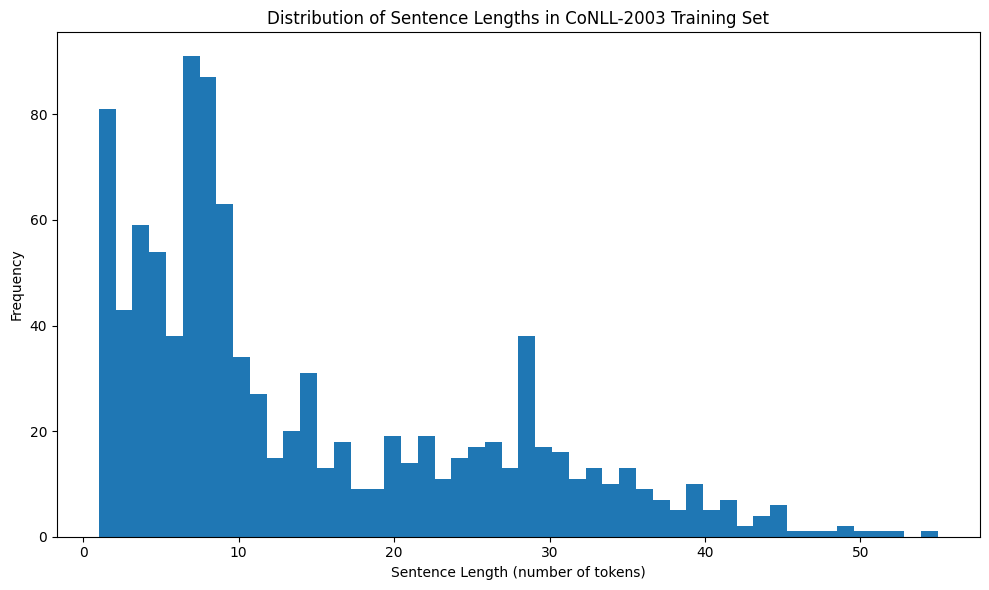


Sentence Length Statistics (Training Set):
Mean: 14.54
Median: 9.0
Max: 55
Min: 1


In [84]:
sentence_lengths = [len(example["tokens"]) for example in dataset["train"]]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50)
plt.xlabel("Sentence Length (number of tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths in CoNLL-2003 Training Set")
plt.tight_layout()
plt.show()

import numpy as np
print("\nSentence Length Statistics (Training Set):")
print(f"Mean: {np.mean(sentence_lengths):.2f}")
print(f"Median: {np.median(sentence_lengths)}")
print(f"Max: {np.max(sentence_lengths)}")
print(f"Min: {np.min(sentence_lengths)}")

In [85]:
from transformers import AutoTokenizer
from datasets import DatasetDict

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding=False
    )

    all_labels = examples["ner_tags"]
    aligned_labels = []
    word_ids_list = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        current_word_ids = []

        for word_idx in word_ids:
            current_word_ids.append(word_idx)

            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)
        word_ids_list.append(current_word_ids)

    tokenized["labels"] = aligned_labels
    tokenized["word_ids"] = word_ids_list
    return tokenized

tokenized_dataset = DatasetDict({
    split: ds.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=["tokens", "pos_tags", "chunk_tags", "ner_tags"]
    )
    for split, ds in dataset.items()
})

tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "word_ids"]
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [104]:
from transformers import (
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
import evaluate
import numpy as np

data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the list of integer label IDs and their corresponding string names
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list_str = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
num_labels = len(label_list)

model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels
)

metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)

    true_preds, true_labels = [], []
    for pred_row, label_row in zip(preds, labels):
        temp_preds, temp_labels = [], []
        for p_id, l_id in zip(pred_row, label_row):
            if l_id != -100:
                # Convert integer IDs back to string labels
                temp_preds.append(label_list_str[p_id])
                temp_labels.append(label_list_str[l_id])
        true_preds.append(temp_preds)
        true_labels.append(temp_labels)

    results = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall":    results["overall_recall"],
        "f1":        results["overall_f1"],
        "accuracy":  results["overall_accuracy"],
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

metrics = trainer.evaluate()
print(metrics)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.453800,0.112913,0.817927,0.800000,0.808864,0.967762
2,0.107900,0.057557,0.887399,0.906849,0.897019,0.984829
3,0.049200,0.054223,0.911051,0.926027,0.918478,0.987674


{'eval_loss': 0.05422251299023628, 'eval_precision': 0.9110512129380054, 'eval_recall': 0.9260273972602739, 'eval_f1': 0.9184782608695652, 'eval_accuracy': 0.9876738305941846, 'eval_runtime': 42.1645, 'eval_samples_per_second': 4.743, 'eval_steps_per_second': 0.308, 'epoch': 3.0}


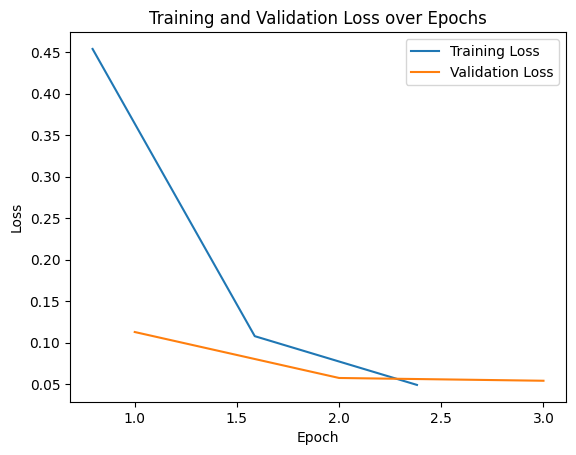

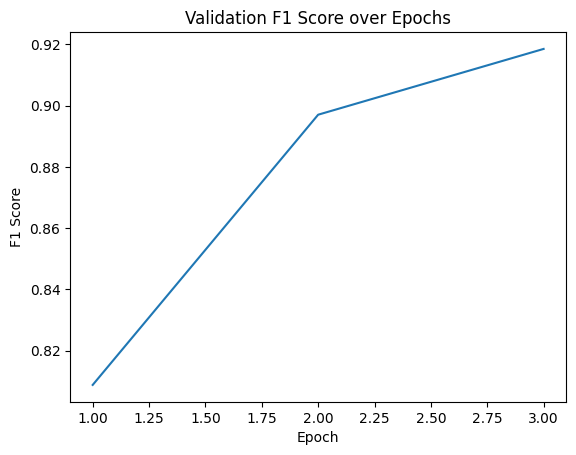

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

df = pd.DataFrame(log_history)

plt.figure()
plt.plot(df['epoch'][df['loss'].notna()], df['loss'][df['loss'].notna()])
plt.plot(df['epoch'][df['eval_loss'].notna()], df['eval_loss'][df['eval_loss'].notna()])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

plt.figure()
plt.plot(df['epoch'][df['eval_f1'].notna()], df['eval_f1'][df['eval_f1'].notna()])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.show()

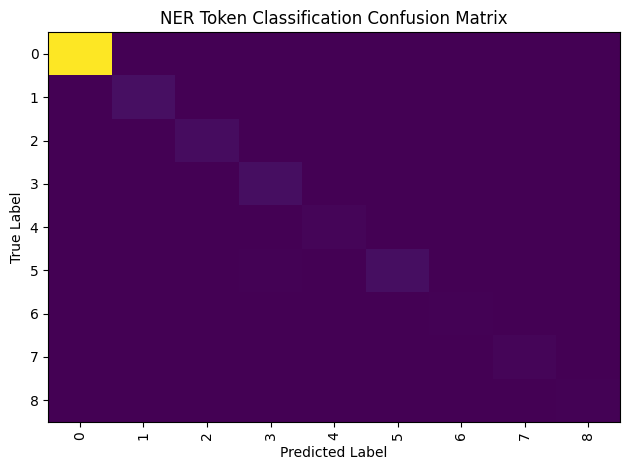

In [106]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

predictions_output = trainer.predict(tokenized_dataset["test"])
predictions, labels, _ = predictions_output.predictions, predictions_output.label_ids, predictions_output.metrics

preds = np.argmax(predictions, axis=2)

true_labels_flat = []
pred_labels_flat = []
for pred_row, label_row in zip(preds, labels):
    for p, l in zip(pred_row, label_row):
        if l != -100:
            true_labels_flat.append(label_list[l])
            pred_labels_flat.append(label_list[p])

cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=label_list)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(len(label_list)), label_list, rotation=90)
plt.yticks(range(len(label_list)), label_list)
plt.title('NER Token Classification Confusion Matrix')
plt.tight_layout()
plt.show()

# 3. Results and Evaluation

This section presents the evaluation of the trained model on the test dataset, including key metrics and a confusion matrix.

In [107]:
test_results = trainer.evaluate(tokenized_dataset["test"])

print("Test Set Evaluation Results:")
print(test_results)

Test Set Evaluation Results:
{'eval_loss': 0.13197697699069977, 'eval_precision': 0.8, 'eval_recall': 0.8439306358381503, 'eval_f1': 0.8213783403656822, 'eval_accuracy': 0.9678200692041522, 'eval_runtime': 53.2541, 'eval_samples_per_second': 3.756, 'eval_steps_per_second': 0.244, 'epoch': 3.0}


## Confusion Matrix

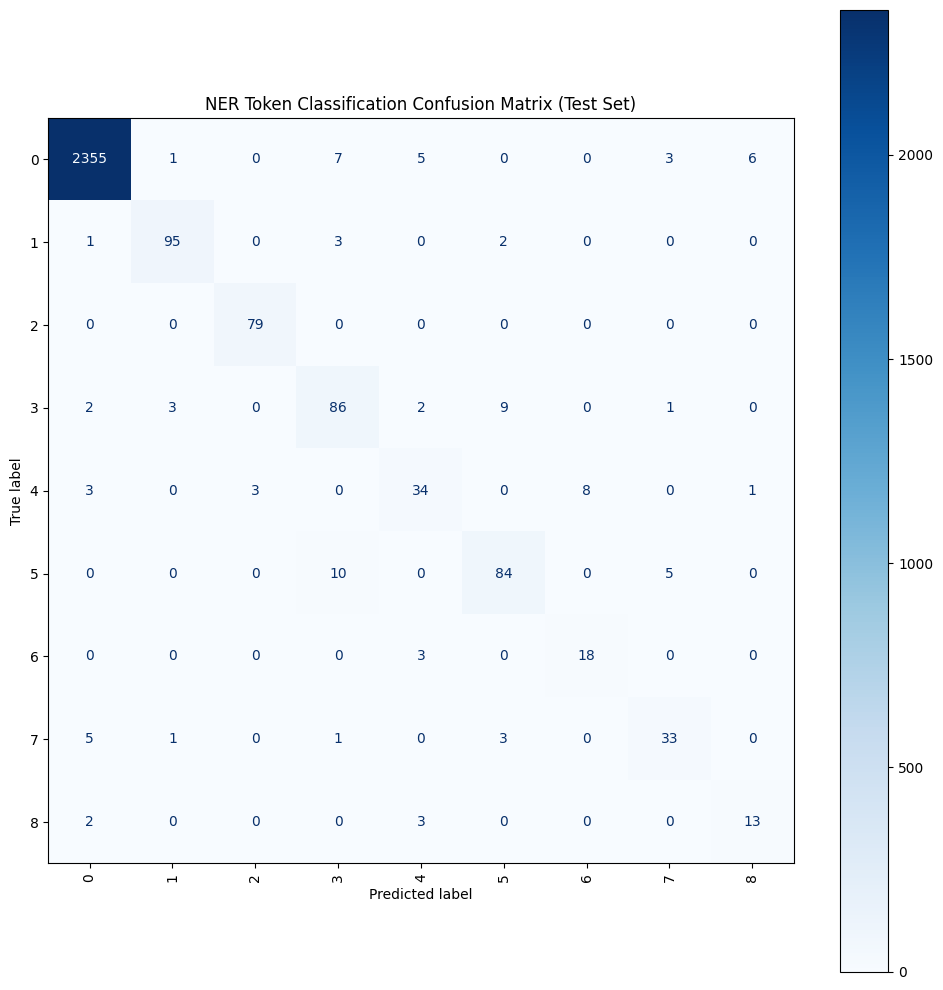

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

predictions_output = trainer.predict(tokenized_dataset["test"])
predictions, labels, _ = predictions_output.predictions, predictions_output.label_ids, predictions_output.metrics

preds = np.argmax(predictions, axis=2)

true_labels_flat = []
pred_labels_flat = []
for pred_row, label_row in zip(preds, labels):
    for p, l in zip(pred_row, label_row):
        if l != -100:
            true_labels_flat.append(label_list[l])
            pred_labels_flat.append(label_list[p])

cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=label_list)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
plt.title('NER Token Classification Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_flat, pred_labels_flat))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2377
           1       0.95      0.94      0.95       101
           2       0.96      1.00      0.98        79
           3       0.80      0.83      0.82       103
           4       0.72      0.69      0.71        49
           5       0.86      0.85      0.85        99
           6       0.69      0.86      0.77        21
           7       0.79      0.77      0.78        43
           8       0.65      0.72      0.68        18

    accuracy                           0.97      2890
   macro avg       0.82      0.85      0.84      2890
weighted avg       0.97      0.97      0.97      2890



## Example Prediction

Let's see an example prediction from the trained model on a sentence from the test set.

In [112]:
from transformers import AutoTokenizer
import torch

raw_example = dataset["test"][0]
words     = raw_example["tokens"]
gold_tags = [ label_list[i] for i in raw_example["ner_tags"] ]

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
inputs = tokenizer(
    words,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True
).to(model.device)

# Add code to get model predictions
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits.squeeze(0)
pred_ids = logits.argmax(dim=-1).tolist()


word_ids = inputs.word_ids(batch_index=0)

pred_tags = []
prev_word_idx = None

for subtoken_idx, word_idx in enumerate(word_ids):
    if word_idx is None:
        continue
    if word_idx != prev_word_idx:
        pred_tags.append(label_list_str[pred_ids[subtoken_idx]]) # Use label_list_str
    prev_word_idx = word_idx

print("Words:     ", words)
print("Gold tags: ", gold_tags)
print("Pred tags: ", pred_tags)

Words:      ['Hartford', '4', 'BOSTON', '2']
Gold tags:  [3, 0, 3, 0]
Pred tags:  ['B-ORG', 'O', 'B-ORG', 'O']


## Example Prediction

Let's see an example prediction from the trained model on a sentence from the test set to qualitatively assess its performance.

In [113]:
from transformers import AutoTokenizer
import torch

sentence = "The event in New York attracted thousands."
words = sentence.split()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
inputs = tokenizer(
    words,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True
).to(model.device)

word_ids = inputs.word_ids(batch_index=0)

pred_tags = []
prev_word_idx = None

with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits.squeeze(0)
pred_ids = logits.argmax(dim=-1).tolist()

for subtoken_idx, word_idx in enumerate(word_ids):
    if word_idx is None:
        continue
    if word_idx != prev_word_idx:
        pred_tags.append(label_list[pred_ids[subtoken_idx]])
    prev_word_idx = word_idx

print("Sentence: ", sentence)
print("Words:    ", words)
print("Pred tags:", pred_tags)

Sentence:  The event in New York attracted thousands.
Words:     ['The', 'event', 'in', 'New', 'York', 'attracted', 'thousands.']
Pred tags: [0, 0, 0, 5, 6, 0, 0]
